In [ ]:
from danial import model
from danial import dataloader


import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur

In [ ]:
mod = model.Model()

/home/ubd/23b6034/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubd/23b6034/MHNet/vengeance/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
test = dataloader.load_image("/home/ubd/23b6034/MHNet/assets/COD10K-CAM-1-Aquatic-1-BatFish-2.jpg")
# Load pretrained weights from models/first600 (robust to common checkpoint formats)
checkpoint_path = "models/first600/best.pth"
try:
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    # checkpoint may be a dict with 'state_dict' or may be the state_dict itself
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state = ckpt['state_dict']
    elif isinstance(ckpt, dict) and all(not isinstance(v, dict) for v in ckpt.values()):
        # likely already a state_dict-like mapping
        state = ckpt
    else:
        state = ckpt
except Exception as e:
    print(f"Failed to load checkpoint {checkpoint_path}: {e}")
    state = None
if state is not None:
    from collections import OrderedDict
    new_state = OrderedDict()
    for k, v in state.items():
        # remove DataParallel/DistributedDataParallel 'module.' prefix if present
        new_k = k.replace('module.', '') if k.startswith('module.') else k
        new_state[new_k] = v
    try:
        mod.load_state_dict(new_state, strict=False)
        print(f"Loaded weights from {checkpoint_path}")
    except Exception as e:
        print(f"Failed to load state dict into model: {e}")
mod.eval()
with torch.no_grad():
    binary_pred, boundary_pred, fused_feat = mod(test)

Loaded weights from models/first600/best.pth


In [ ]:
print(binary_pred.shape, boundary_pred.shape, fused_feat.shape)

torch.Size([1, 5]) torch.Size([1, 4]) torch.Size([1, 64, 7, 7])


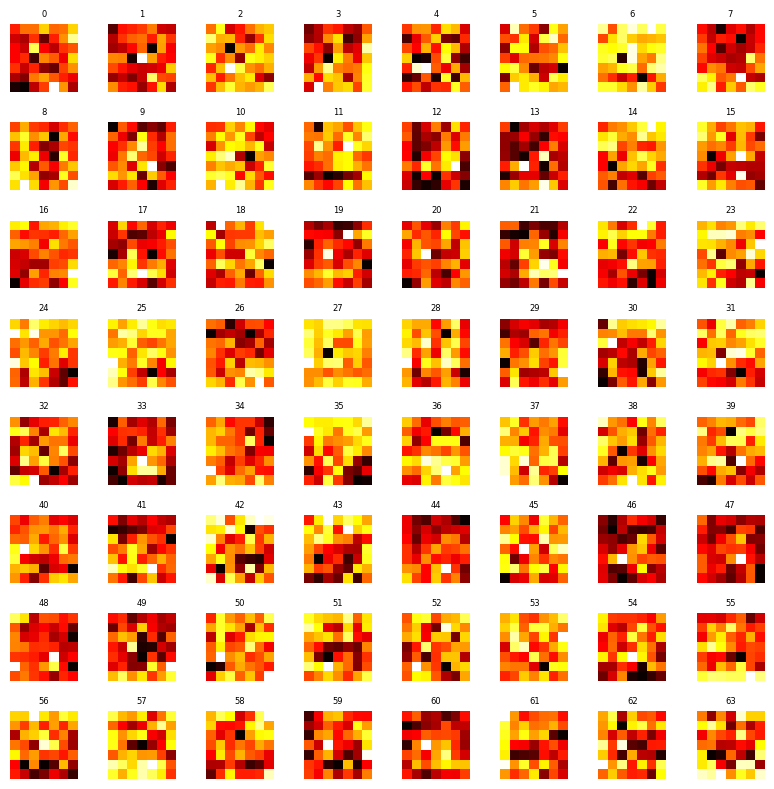

In [ ]:
# Plot all 64 channels in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i in range(64):
    ax = axes[i // 8, i % 8]
    ax.imshow(fused_feat[0, i].detach().cpu(), cmap='hot')
    ax.axis('off')
    ax.set_title(f"{i}", fontsize=6)

plt.tight_layout()
plt.show()


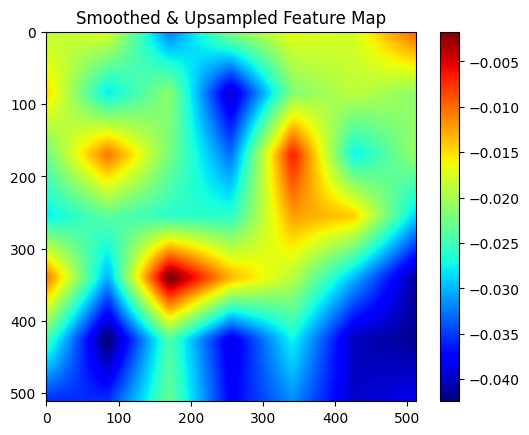

In [ ]:
avg_map = fused_feat.mean(dim=1, keepdim=True)  # [1, 1, 7, 7]

# 1️⃣ Upsample to higher resolution (e.g., 224x224)
upsampled = F.interpolate(avg_map, size=(512,512), mode='bilinear', align_corners=True)

# 2️⃣ Apply Gaussian blur
blur = GaussianBlur(kernel_size=(15,15), sigma=(4.0,4.0))
smoothed = blur(upsampled)

# 3️⃣ Show result
plt.imshow(smoothed[0, 0].detach().cpu(), cmap='jet')  # using 'jet' for heatmap look
plt.title("Smoothed & Upsampled Feature Map")
plt.colorbar()
plt.show()
